In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import seaborn as sns
# sns.set_style("dark")

from sklearn import preprocessing
from scipy.stats import skew, boxcox

import warnings
warnings.filterwarnings("ignore")

print('done')

done


In [3]:
dt = pd.read_csv('../data/data.csv')

dt.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

In [4]:
dt.info()

dt.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
50%      1.327057e+05    2.146614e+05  0.000000e+00    0.000000e+00  
75%      9.430367e+05    1.111909e+06  0.000000e+00    0.000000e+00  
max      3.560159e+08    3.561793e+08  1.000000e+00    1.000000e+00

In [5]:
dt.columns


Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

## 列名解释
nameOrig:转账发起人 

oldbalanceOrg：转账前发起人余额 

newbalanceOrig：转账后发起人余额 

nameDest：转账收款人 

oldbalanceDest：转账前收款人余额 

newbalanceDest：转账后收款人余额 

isFraud：label 

isFlaggedFraud：label + 大额转账导致的非法操作（>200000）

# EDA

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


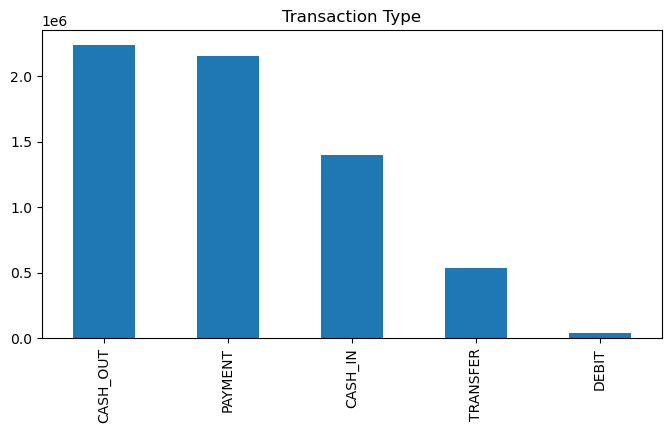

In [6]:
print(dt.type.value_counts())

fig, ax = plt.subplots(1, 1, figsize = (8, 4))
dt.type.value_counts().plot(kind = 'bar', title = 'Transaction Type', ax = ax, figsize=(8, 4))
plt.show()

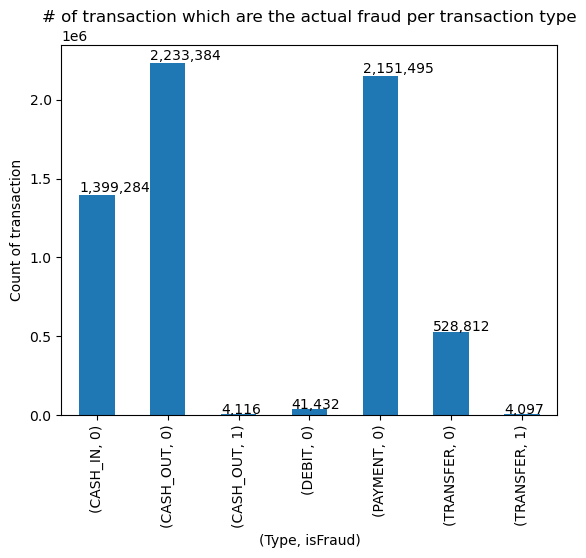

In [7]:
ax = dt.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

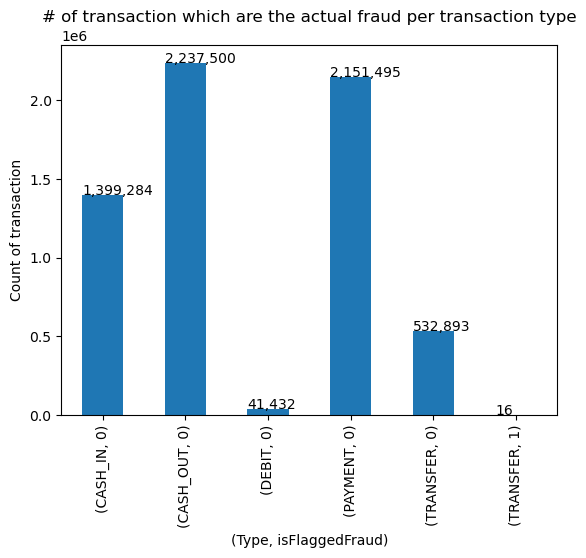

In [8]:
ax = dt.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFlaggedFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.0))

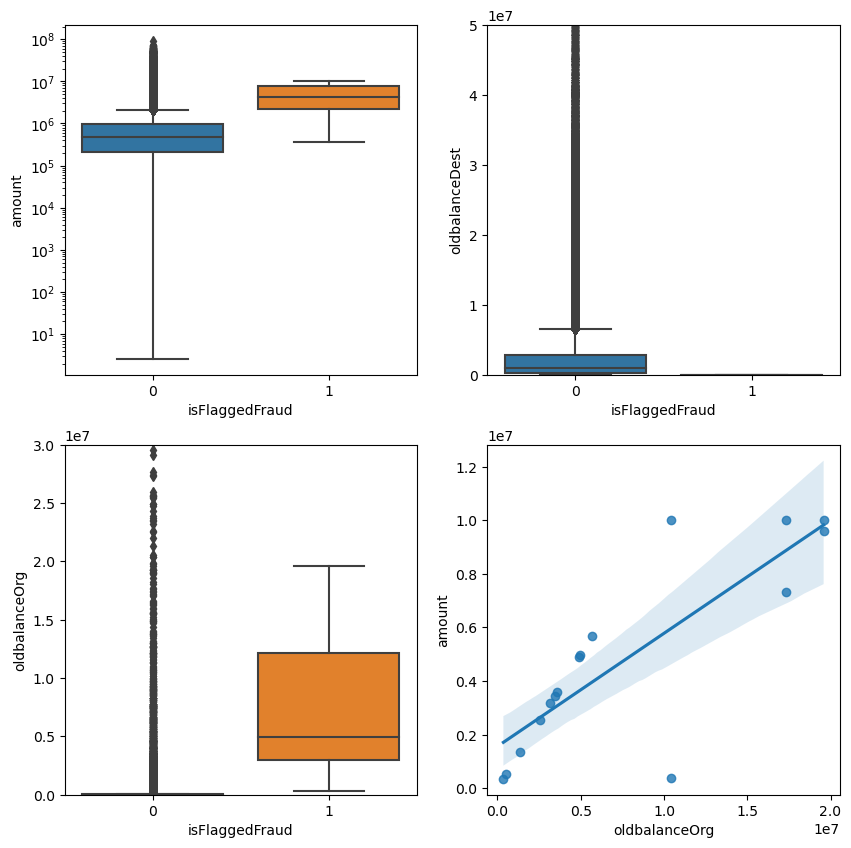

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
tmp = dt.loc[(dt.type == 'TRANSFER'), :]

a = sns.boxplot(x = 'isFlaggedFraud', y = 'amount', data = tmp, ax=axs[0][0])
axs[0][0].set_yscale('log')
b = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceDest', data = tmp, ax=axs[0][1])
axs[0][1].set(ylim=(0, 0.5e8))
c = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceOrg', data=tmp, ax=axs[1][0])
axs[1][0].set(ylim=(0, 3e7))
d = sns.regplot(x = 'oldbalanceOrg', y = 'amount', data=tmp.loc[(tmp.isFlaggedFraud ==1), :], ax=axs[1][1])
plt.show()

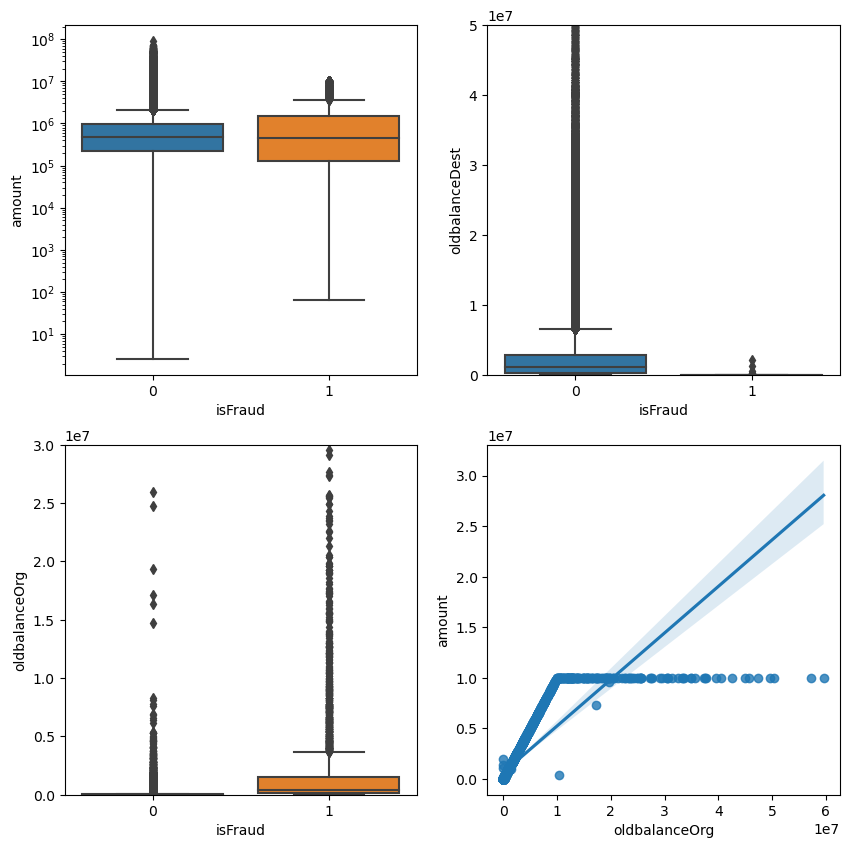

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
tmp = dt.loc[(dt.type == 'TRANSFER'), :]

a = sns.boxplot(x = 'isFraud', y = 'amount', data = tmp, ax=axs[0][0])
axs[0][0].set_yscale('log')
b = sns.boxplot(x = 'isFraud', y = 'oldbalanceDest', data = tmp, ax=axs[0][1])
axs[0][1].set(ylim=(0, 0.5e8))
c = sns.boxplot(x = 'isFraud', y = 'oldbalanceOrg', data=tmp, ax=axs[1][0])
axs[1][0].set(ylim=(0, 3e7))
d = sns.regplot(x = 'oldbalanceOrg', y = 'amount', data=tmp.loc[(tmp.isFraud ==1), :], ax=axs[1][1])
plt.show()

# preprocess

In [11]:
# clean the data
use_dt = dt.loc[(dt.type.isin(['TRANSFER', 'CASH_OUT'])), :]
use_dt.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1, inplace = True)
tmp = use_dt.reset_index(drop = True)

# transfer  cash_out -> {0, 1}
# 可以修改后边的处理
type_label_encoder = preprocessing.LabelEncoder()
type_category = type_label_encoder.fit_transform(tmp['type'].values)
tmp['typeCategory'] = type_category

tmp.head()

type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0  TRANSFER     181.00          181.0             0.0             0.0   
1  CASH_OUT     181.00          181.0             0.0         21182.0   
2  CASH_OUT  229133.94        15325.0             0.0          5083.0   
3  TRANSFER  215310.30          705.0             0.0         22425.0   
4  TRANSFER  311685.89        10835.0             0.0          6267.0   

   newbalanceDest  isFraud  typeCategory  
0            0.00        1             1  
1            0.00        1             0  
2        51513.44        0             0  
3            0.00        0             1  
4      2719172.89        0             1

<Axes: >

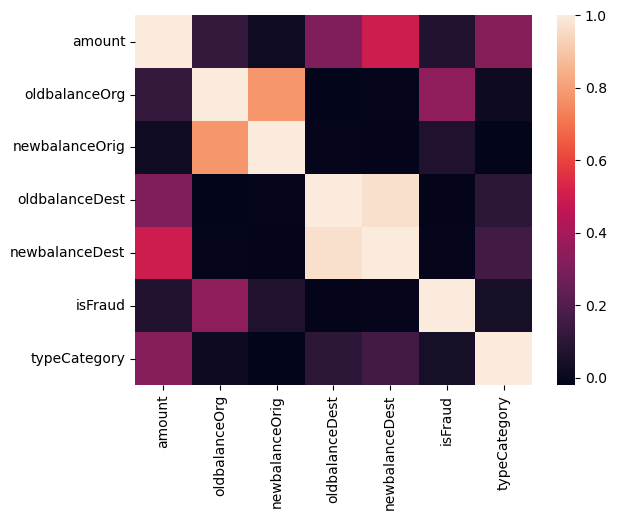

In [12]:
# def correlation_plot(df):
#     fig = plt.figure(figsize=(10, 10))
#     ax1 = fig.add_subplot(111)
#     cmap = cm.get_cmap('jet', 30)
#     cax = ax1.imshow(df.corr(), interpolation = "nearest", cmap = cmap)
# #     ax1.grid(True)
# #     plt.title("Correlation Heatmap")
#     labels = df.columns.tolist()
#     ax1.set_xticklabels(labels, fontsize=13, rotation=45)
#     ax1.set_yticklabels(labels, fontsize=13)
#     fig.colorbar(cax)
#     plt.show()
    
# correlation_plot(use_dt)

sns.heatmap(tmp.corr())

CASH_OUT    2237500
TRANSFER     532909
Name: type, dtype: int64


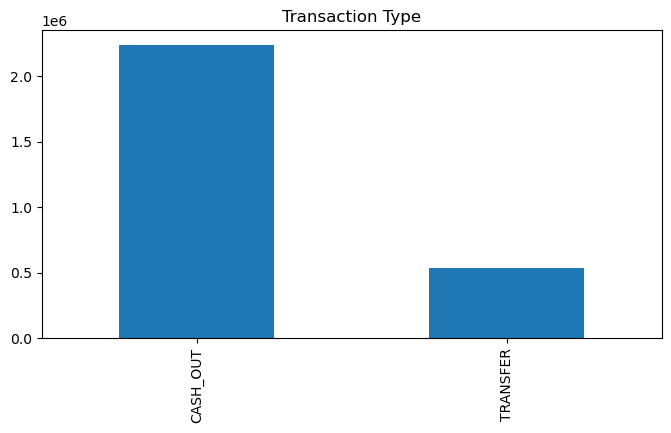

In [13]:
print(tmp.type.value_counts())

fig, ax = plt.subplots(1, 1, figsize = (8, 4))
tmp.type.value_counts().plot(kind = 'bar', title = 'Transaction Type', ax = ax, figsize=(8, 4))
plt.show()

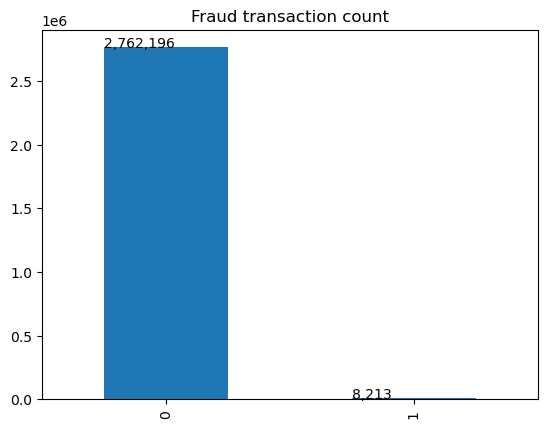

In [14]:

ax = pd.value_counts(tmp['isFraud'], sort = True).sort_index().plot(kind='bar', title="Fraud transaction count")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
    
plt.show()



In [15]:
feature_names = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'typeCategory']

x = tmp[feature_names]

y = tmp['isFraud']

print(x.head())

print('\n')

print(y.head())


      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0     181.00          181.0             0.0             0.0            0.00   
1     181.00          181.0             0.0         21182.0            0.00   
2  229133.94        15325.0             0.0          5083.0        51513.44   
3  215310.30          705.0             0.0         22425.0            0.00   
4  311685.89        10835.0             0.0          6267.0      2719172.89   

   typeCategory  
0             1  
1             0  
2             0  
3             1  
4             1  


0    1
1    1
2    0
3    0
4    0
Name: isFraud, dtype: int64


In [16]:
tmp.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'amount', 'type'], axis=1, inplace=True)

X = tmp.iloc[:, tmp.columns != 'isFraud']
y = tmp.iloc[:, tmp.columns == 'isFraud']

# tmp.head()

# LR

In [17]:
# non-balance, undersample 降采样
# Number of data points in the minority class
number_records_fraud = len(tmp[tmp.isFraud == 1])
fraud_indices = tmp[tmp.isFraud == 1].index.values

# Picking the indices of the normal classes
normal_indices = tmp[tmp.isFraud == 0].index

# Out of the indices we picked, randomly select "x" number (x - same as total fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])
under_sample_data = tmp.iloc[under_sample_indices, :]

X_undersample = under_sample_data.iloc[:, (under_sample_data.columns != 'isFraud')]
y_undersample = under_sample_data.iloc[:, (under_sample_data.columns == 'isFraud')]

print('done')


done


[[0.99814495 0.00185505]
 [0.99814495 0.00185505]
 [0.99814495 0.00185505]
 ...
 [0.99814495 0.00185505]
 [0.99814495 0.00185505]
 [0.99238044 0.00761956]]
0.6584673509866245


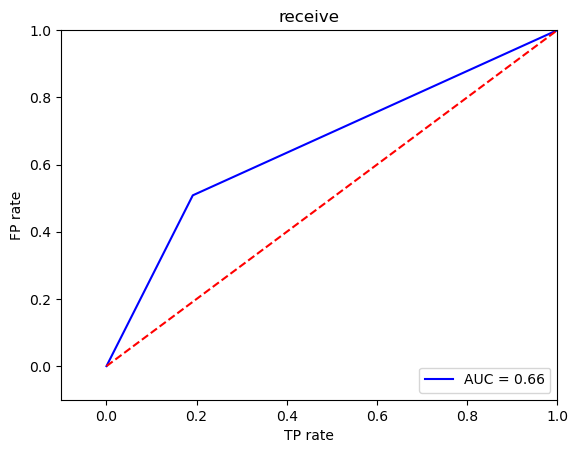

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

from sklearn.model_selection import train_test_split

# undersample dataset
# X_train, X_test, y_train, y_test = train_test_split(X_undersample ,y_undersample,test_size = 0.001,random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X ,y,test_size = 0.3,random_state = 0)

# print(X_train.info())
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


# y_train = y_train.ravel()

lr_model = LogisticRegression()
lr_model.fit(X_train, 
             y_train)

y_pred_score = lr_model.predict_proba(X_test)
print(y_pred_score)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_score[:, 1])
roc_auc = auc(fpr, tpr)

print('{}'.format(roc_auc))

plt.title('receive')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.0])
plt.xlabel('TP rate')
plt.ylabel('FP rate')
plt.show()

# XGBOOST

In [19]:
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

X = dt.loc[(dt.type.isin(['TRANSFER', 'CASH_OUT'])), :]

randomState = 5
np.random.seed(randomState)

Y = X['isFraud']
# 不删这列，预测率100%楽
del X['isFraud']

X.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1, inplace = True)
X = X.reset_index(drop = True)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)



In [22]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
# probabilities = clf.fit(trainX, trainY).predict_proba(testX)
# print('AUPRC = {}'.format(average_precision_score(testY, \
#                                               probabilities[:, 1])))
clf.fit(trainX, trainY)

X_train = np.array(trainX)
y_train = np.array(trainY)
X_test = np.array(testX)
y_test = np.array(testY)

y_pred_score = clf.predict_proba(X_test)
print(y_pred_score)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_score[:, 1])
roc_auc = auc(fpr, tpr)

print('{}'.format(roc_auc))

[[9.9984270e-01 1.5728953e-04]
 [9.9936634e-01 6.3363853e-04]
 [9.9992579e-01 7.4225223e-05]
 ...
 [9.9964297e-01 3.5702714e-04]
 [9.9999660e-01 3.3868566e-06]
 [9.9998653e-01 1.3477292e-05]]
0.9987628880093443
